# Denoising 2D Generated Datasets - classifier free guidance

In [ ]:
using Plots
using Flux
using BSON
using JSON
using StatsBase
using Printf

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!

In [ ]:
includet("../common/datasets.jl");
includet("../common/utilities.jl");
includet("../common/argmin_func.jl");

## Test

### load model

In [ ]:
directory = "../models/2d_cond_20230824_2215";
diffusion_path = joinpath(directory, "diffusion.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
BSON.@load diffusion_path diffusion
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (2,)
num timesteps: 40


ConditionalChain(
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(2 => 32),                     # 96 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(32 => 32),                    # 1_056 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(32 => 32),                    # 1_056 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Dense(32 => 2),                       # 66 paramet

In [ ]:
history = JSON.parsefile(history_path)

Dict{String, Any} with 4 entries:
  "epoch_size"      => 282
  "mean_batch_loss" => Any[1.05209, 0.992086, 0.956071, 0.940027, 0.946344, 0.9…
  "batch_size"      => 32
  "val_loss"        => Any[0.985892, 0.967553, 0.967193, 0.89215, 0.931853, 0.9…

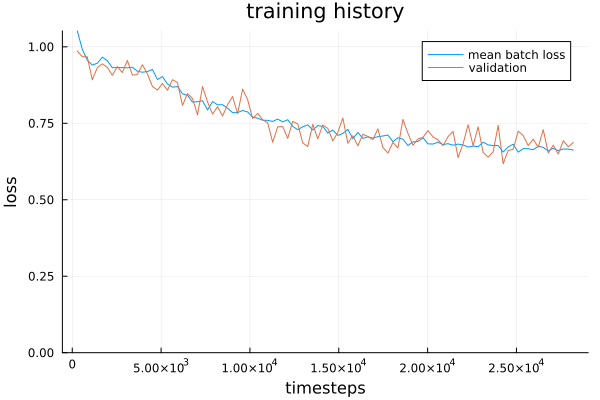

In [ ]:
timesteps = (1:length(history["mean_batch_loss"])) * history["epoch_size"]

canvas_train = plot(timesteps, history["mean_batch_loss"], 
    label="mean batch loss", ylims=(0, Inf),
    title="training history",
    xlabel="timesteps",
    ylabel="loss",
)
plot!(canvas_train, timesteps, history["val_loss"], label="validation")
savefig(canvas_train, joinpath(directory, "history.png"))
canvas_train

### sample

In [ ]:
num_samples = 1000
x_gen = Dict{Int, Dict{Symbol, Array{Float32, 3}}}()
γ = 1.0f0
for label in 1:4
    Xs, X0s = p_sample_loop_all(diffusion, 1000, label; guidance_scale=γ, clip_denoised=false)
    x_gen[label] = Dict(
        :Xs => Xs,
        :X0s => X0s
    )
end

Sampling... 100%|████████████████████████████████████████| Time: 0:00:06
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00


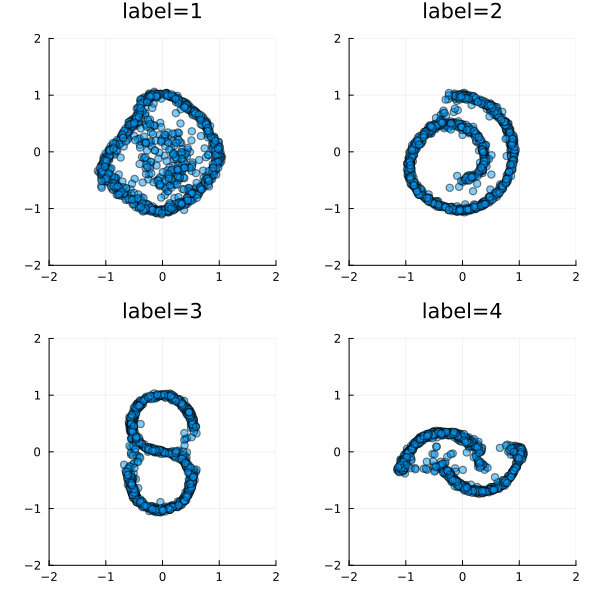

In [ ]:
canvases = []
for label in 1:4
    X0 = x_gen[label][:Xs][:, : , end]
    p0 = scatter(X0[1, :], X0[2, :], alpha=0.5, label="",
        aspectratio=:equal,
        xlims=(-2, 2), ylims=(-2, 2),
        title="label=$label",
        size=(600, 600),
    )
    push!(canvases, p0)
end
canvas_samples = plot(canvases...)
savefig(canvas_samples, joinpath(directory, "samples.png"))
canvas_samples

### Animations 

In [ ]:
anim_denoise = @animate for i ∈ 1:(num_timesteps + 10)
   i = i > num_timesteps ? num_timesteps : i
    canvases = []
    for label in 1:4
        X = x_gen[label][:Xs][:, : , i]
        p0 = scatter(X[1, :], X[2, :], alpha=0.5, label="",
            aspectratio=:equal,
            xlims=(-2, 2), ylims=(-2, 2),
            title="label=$label",
            size=(600, 600),
        )
        push!(canvases, p0)
    end
    p = plot(canvases...)
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_Y1Guy2", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

[ Info: Saved animation to C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\models\2d_cond_20230824_2215\reverse.gif


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion-examples\\models\\2d_cond_20230824_2215\\reverse.gif")
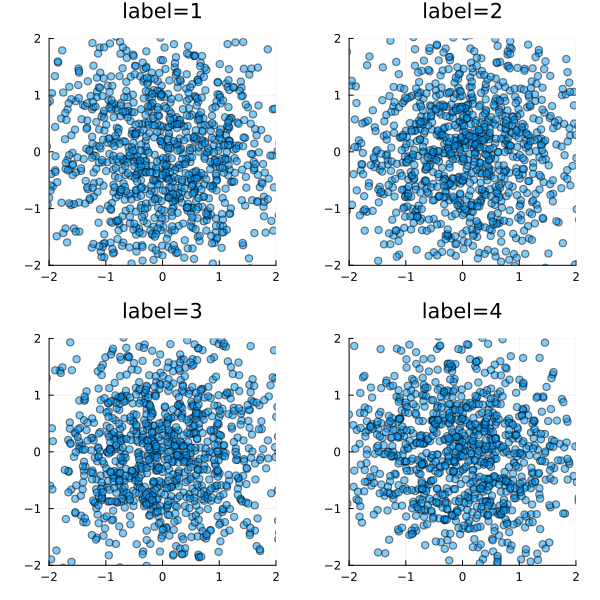

In [ ]:
gif(anim_denoise, joinpath(directory, "reverse.gif"), fps=8)

In [ ]:
anim_estimates = @animate for i ∈ 1:(num_timesteps + 10)
    i= i > num_timesteps ? num_timesteps : i
    canvases = []
    for label in 1:4
        X0s = x_gen[label][:X0s][:, : , i]
        p0 = scatter(X0s[1, :], X0s[2, :], alpha=0.5, label="",
            aspectratio=:equal,
            xlims=(-2, 2), ylims=(-2, 2),
            title="label=$label",
            size=(600, 600),
        )
        push!(canvases, p0)
    end
    p = plot(canvases...)
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_yxMQdS", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

[ Info: Saved animation to C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\models\2d_cond_20230824_2215\estimates.gif


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion-examples\\models\\2d_cond_20230824_2215\\estimates.gif")
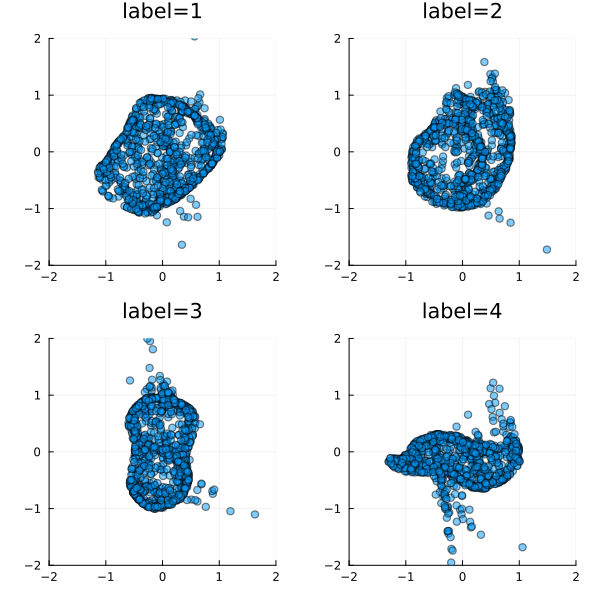

In [ ]:
gif(anim_estimates, joinpath(directory, "estimates.gif"), fps=8)